In [10]:
%matplotlib inline

import numpy as np;
import time;
from numba import jit
from numba import vectorize
import accelerate
from copy import deepcopy;
import matplotlib
import matplotlib.pyplot as plt
from IPython import display
import matplotlib.animation as manimation
import winsound

(2, 12618)


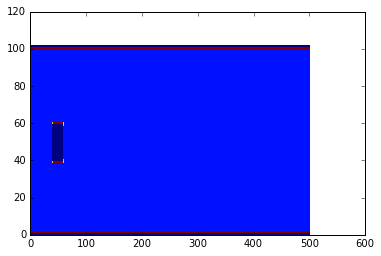

In [5]:
# GRID

#           4    3    2
#
#           5    0    1
#
#           6    7    8

# Define variables used
directions               = 9;
relaxation_constant      = 0.8;
grid_step_x              = 2E-3;
grid_step_y              = 1E-2;
speed_of_sound           = 1;
time_step                = 1 / speed_of_sound;
directional_weights      = np.array([16,4,1,4,1,4,1,4,1], dtype=np.double) / 36;
unit_x_velocities        = np.array([0, 1, 1, 0, -1, -1, -1, 0, 1], dtype=np.int);
unit_y_velocities        = np.array([0, 0, 1, 1, 1, 0, -1, -1, -1], dtype=np.int);
ei                       = np.stack((unit_x_velocities, unit_y_velocities));
oppositeDirection        = np.array([0, 5, 6, 7, 8, 1, 2, 3, 4], dtype=np.int64);
density                  = 1E0;
mass                     = 1E0;
particles_per_grid_point = 1E1;
average_density          = particles_per_grid_point;
inlet_velocity           = 0.2;

# Create the grid. We use a triangular grid
x          = np.linspace(0, 1, 1 / grid_step_x + 1);
y          = np.linspace(-grid_step_y/2, 1 + grid_step_y/2, 1/grid_step_y + 2);
[X, Y]     = np.meshgrid(x,y)     # This is a rectangular grid

# Create the velocity grid.
u           = np.ones(np.shape(x)) * inlet_velocity;
v           = np.zeros(np.shape(y));
[U, V]      = np.meshgrid(u,v);
U = np.dstack((U,V)).astype(np.double);

# Place walls etc
Active = np.ones(X.shape).astype(np.double);
Active[[0,-1],:] = 0; # Top and bottom boundary
Active[40:60, 40:60] = 0; # Block

# Calculate the boundary elements
Boundary = np.zeros(X.shape, dtype=np.double);
for i in range(1,9):
    Boundary = Boundary + np.roll(np.roll(Active, np.int(ei[0,i]), axis=1), np.int(ei[1,i]), axis=0);

# All locations which are smaller than 8 and active are a boundary
Boundary = ((8 - Boundary) * Active > 0) * (8 - Boundary);
BoundaryList = np.zeros([np.int(np.sum(Boundary)),4]);
BoundaryPositions = np.nonzero(Active==0);
BoundaryPositions = np.tile(BoundaryPositions, 9);
#BoundaryPositions = np.swapaxes(BoundaryPositions, 2,0)
print(BoundaryPositions.shape);

Arr = np.tile(np.arange(9), (np.int(BoundaryPositions.shape[1]/9),1))
Arr = np.reshape(Arr, Arr.size,1).astype(np.int64);

#print(BoundaryPositions);
#z = 0;
#ActiveShape = Active.shape - np.array([1,1]);
#for i in np.transpose(BoundaryPositions):
 #   for j in range(1,9):
#?p = i + ei[:,j];
#   #     BoundaryList[z,:] = [i[0],i[1],j,oppositeDirection[j]];
#        z = z + 1;
#BoundaryList = BoundaryList[~np.all(BoundaryList == 0, axis=1)].astype(int);
#print(BoundaryList);
#
plt.pcolor(Boundary * 2 + Active);

# Create a movie!!
#Movie = 1;
#FFMpegWriter = manimation.writers['ffmpeg']
#metadata = dict(title='Movie Test', artist='Matplotlib',
 #               comment='Movie support!')
#writer = FFMpegWriter(fps=30, metadata=metadata)


In [11]:
#@jit(['float32(float32, float32, int8, int8, int8)'], nopython=True)
#@jit([np.double, np.double, np.double, np.double, np.double])

#@accelerate(['f8(f8, f8, f8, int64, int64, int64)'], target='parallel')
@vectorize(['f8(f8, f8, f8, int64, int64, int64)'], target='parallel')
def equil(f_eq, U, rho, W, C, ei):
    #f_eq   = np.zeros((U.shape[0], U.shape[1], ei.shape[1]), dtype=np.float32);
    # Calculate the equilibirum
    a = np.dot(U,ei);
    #a = 
    #a = U[:,:,0] * ei[:,0] + U[:,:,1] * ei[:,1]
    b = np.power(a,2);
    c = np.power(U[:,:,0],2) + np.power(U[:,:,1],2);
    for i in range(0,directions):
        f_eq[:,:,i] = directional_weights[i] * rho * (
            1 + 
            6 / 2 * a[:,:,i] * C ** -2 + 
            9 / 2 * b[:,:,i] * C ** -4 -
            3 / 2 * c[:,:] * C ** -2
        );
    #return f_eq;

TypeError: data type "pyobject" not understood

In [24]:
time_steps = 500;

C = speed_of_sound;
tau = relaxation_constant;

f_init = np.zeros((Active.shape[0], Active.shape[1], directions), dtype=np.double)
f_prev = np.zeros((Active.shape[0], Active.shape[1], directions), dtype=np.double)
f_next = np.zeros((Active.shape[0], Active.shape[1], directions), dtype=np.double)
f_eq   = np.zeros((Active.shape[0], Active.shape[1], directions), dtype=np.double)
f_temp = np.zeros((Active.shape[0], Active.shape[1], directions), dtype=np.double)

rho = np.ones(Active.shape, dtype=np.double);

equil(f_prev, U, rho, directional_weights, C, ei);
#f_next[BoundaryPositions[0,:], BoundaryPositions[1,:], Arr] = 0;

start_time = time.clock();
fig = plt.figure(num=None, figsize=(15,3), dpi=300);
#with writer.saving(fig, "writer_test.mp4", 100):
for t in range(time_steps):
    # Reset
    f_next[:,:,:] = 0;

    # Outflow condition
    f_prev[:,-1,:] = f_prev[:,-2,:]

    rho = np.sum(f_prev, axis=2);
    has_rho = np.logical_and(Active==1,rho>0);
    U[:,:,:] = 0;
    U[has_rho,::] = np.divide(
        np.dot(f_prev, np.transpose(ei))[has_rho,:] ,
        rho[has_rho,np.newaxis]
    );
    U[:,0,0] = np.ones(U.shape[0]) * inlet_velocity + inlet_velocity * 0.1 * np.sin(np.arange(U.shape[0]) * 6.28 * grid_step_y);
    #U[:,0,0] = inlet_velocity;
    rho[:,0] = 1;

    # Calculate the equilibirum
    
    equil(f_eq, U, rho, directional_weights, C, ei);
    #a = np.dot(U,ei);
    #b = np.power(a,2);
    #c = np.power(U[:,:,0],2) + np.power(U[:,:,1],2);
    #for i in range(0,directions):
    #    f_eq[:,:,i] = directional_weights[i] * rho * (
    #        1 + 
    #        6 / 2 * a[:,:,i] * C ** -2 + 
    #        9 / 2 * b[:,:,i] * C ** -4 -
    #        3 / 2 * c[:,:] * C ** -2
    #    );

    # Collision step
    f_prev[Active == 1,:] = f_prev[Active == 1,:] - 1 / tau * (f_prev[Active == 1,:] - f_eq[Active == 1,:])
    f_prev[0,:,:] = f_eq[0,:,:]; # Inflow condition
    #f_prev[5,0,1] = 1;

    # Streaming step
    for i in range(directions):
        f_next[:,:,i] = np.roll(np.roll(f_prev[:,:,i], np.int(ei[0,i]), axis=1), np.int(ei[1,i]), axis=0);

    #Boundary conditions
    f_next[BoundaryPositions[0,:], BoundaryPositions[1,:], Arr] = f_next[
        BoundaryPositions[0,:], BoundaryPositions[1,:], oppositeDirection[Arr]
    ]

    f_prev[:,:,:] = f_next[:,:,:];
    #if (t%np.int(round(time_steps/10)) == 0):
    if (t%1==0):
        print(str(np.int(t / round(time_steps/100))) + "% Simulating");
        a = 1;
        b = 100;
        #Q = plt.pcolor(X,Y,f_prev[:,:,1]);
        #Q = plt.pcolor(X,Y,U[:,:,0]);
        res = 1;
        Q = plt.pcolor(
            X[0:-1:res, 0:-1:res],
            Y[0:-1:res, 0:-1:res],
            rho[0:-1:res, 0:-1:res],
            vmin=0.94,
            vmax=1.06
        );
        axes = plt.gca()
        axes.set_xlim([0,1])
        axes.set_ylim([0,1])
        if (t == 0):
            plt.colorbar();
        #Q = plt.pcolor(X,Y,np.linalg.norm(U,axis=2));
        #writer.grab_frame()
        #Q = plt.quiver(X,Y,U[:,:,0],U[:,:,1]);
        #Q = plt.quiver(X[::a, ::b],Y[::a, ::b],U[::a, ::b],V[::a, ::b]);
        #Q = plt.quiver(X[::1,::1],Y[::1,::10],U[::1,::10],V[::1,::10],units='width');

        display.clear_output(wait=True);
        display.display(fig);
        print(t);

print(time.clock() - start_time);

TypeError: No matching version.  GPU ufunc requires array arguments to have the exact types.  This behaves like regular ufunc with casting='no'.